In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as ac; ac.set_theme()
import pandas as pd
import matplotlib


In [2]:
fn = "data/fourteenSkillsDen.csv" # Dataset path
verbose = 1 # Verbose = {0,1,2}
best_model_weights = "weights/bestmodel" # File to save the model.
log_dir = "logs" # Path to save the logs.
optimizer = "adam" # Optimizer to use
lstm_units = 150 # Number of LSTM units
batch_size = 32 # Batch size
epochs = 20 # Number of epochs to train
dropout_rate = 0.3 # Dropout rate
test_fraction = 0.2 # Portion of data to be used for testing
validation_fraction = 0.1 # Portion of training data to be used for validation

In [102]:
from deepkt import deepkt, data_util, metrics

batch_size=1
dataset, length, nb_features, nb_skills = data_util.load_dataset(fn=fn,
                                                                 batch_size=batch_size,
                                                                 shuffle=True)

train_set, test_set, val_set = data_util.split_dataset(dataset=dataset,
                                                       total_size=length,
                                                       test_fraction=test_fraction,
                                                       val_fraction=validation_fraction)


set_sz = length * batch_size
test_set_sz = (set_sz * test_fraction)
val_set_sz = (set_sz - test_set_sz) * validation_fraction
train_set_sz = set_sz - test_set_sz - val_set_sz
print("============= Data Summary =============")
print("Total number of students: %d" % set_sz)
print("Training set size: %d" % train_set_sz)
print("Validation set size: %d" % val_set_sz)
print("Testing set size: %d" % test_set_sz)
print("Number of skills: %d" % nb_skills)
print("Number of features in the input: %d" % nb_features)
print("========================================")

============= Data Summary =============
Total number of students: 1167
Training set size: 840
Validation set size: 93
Testing set size: 233
Number of skills: 14
Number of features in the input: 28


In [5]:

train_length=train_set_sz // batch_size
val_length=val_set_sz // batch_size

student_model = deepkt.DKTModel(
                        nb_features=nb_features,
                        nb_skills=nb_skills,
                        hidden_units=lstm_units,
                        dropout_rate=dropout_rate)

student_model.compile(
        optimizer=optimizer,
        metrics=[
            metrics.BinaryAccuracy(),
            metrics.AUC(),
            metrics.Precision(),
            metrics.Recall()
        ])

student_model.summary()

Model: "DKTModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 28)]        0         
_________________________________________________________________
masking (Masking)            (None, None, 28)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 150)         107400    
_________________________________________________________________
outputs (TimeDistributed)    (None, None, 14)          2114      
Total params: 109,514
Trainable params: 109,514
Non-trainable params: 0
_________________________________________________________________


In [6]:
import tensorflow as tf
history = student_model.fit(dataset=train_set,
                            epochs=epochs,
                            verbose=verbose,
                            validation_data=val_set,
                            callbacks=[
                                tf.keras.callbacks.CSVLogger(f"{log_dir}/train.log"),
                                tf.keras.callbacks.ModelCheckpoint(best_model_weights,
                                                                   save_best_only=True,
                                                                   save_weights_only=True),
                                tf.keras.callbacks.TensorBoard(log_dir=log_dir)
        ])

Epoch 1/20


2022-06-04 12:33:06.883443: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_851_2308' and '__inference___backward_standard_lstm_3606_4203_specialized_for_training_Adam_gradients_gradients_lstm_StatefulPartitionedCall_grad_StatefulPartitionedCall_at___inference_keras_scratch_graph_4855' both implement 'lstm_7ddfd040-d4d6-4197-8b71-a4dfd21353bb' but their signatures do not match.


     24/Unknown - 2s 85ms/step - loss: 0.6937 - binary_accuracy: 0.4872 - auc: 0.5258 - precision: 0.4242 - recall: 0.2545

2022-06-04 12:33:07.341170: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


839/839 [==============================] - 9s 11ms/step - loss: 0.6364 - binary_accuracy: 0.6839 - auc: 0.7302 - precision: 0.7235 - recall: 0.7624 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
839/839 [==============================] - 5s 6ms/step - loss: 0.5988 - binary_accuracy: 0.7243 - auc: 0.7770 - precision: 0.7547 - recall: 0.7979 - val_loss: 0.6275 - val_binary_accuracy: 0.7335 - val_auc: 0.7379 - val_precision: 0.7386 - val_recall: 0.9000
Epoch 3/20
839/839 [==============================] - 4s 5ms/step - loss: 0.5901 - binary_accuracy: 0.7141 - auc: 0.7844 - precision: 0.7601 - recall: 0.7620 - val_loss: 0.6244 - val_binary_accuracy: 0.6533 - val_auc: 0.7554 - val_precision: 0.7573 - val_recall: 0.6704
Epoch 4/20
839/839 [==============================] - 5s 5ms/step - loss: 0.5896 - binary_accuracy: 0.7076 - auc: 0.7767 - precision: 0.7485 - recall: 0.7691 - val_loss: 0.6277 - v

In [7]:
student_model.load_weights(best_model_weights)

In [8]:
result = student_model.evaluate(test_set, verbose=verbose)


    234/Unknown - 1s 5ms/step - loss: 0.6011 - binary_accuracy: 0.7348 - auc: 0.7854 - precision: 0.7209 - recall: 0.9055

### Take One Sample

In [103]:
def get_element_by_index(data_set,candidate_index):
    """
    This function gets candidate
    by index
    """
    for raw_index,candidate in enumerate(data_set):
        if raw_index == candidate_index:
            candidate_desired = candidate
            return candidate_desired

In [104]:
student_desired=get_element_by_index(test_set,100)
print(student_desired[0][0])

tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]], shape=(8, 28), dtype=float32)


In [105]:
sample1=np.zeros((1,14,28))

In [106]:
for i in range(14):
    sample1[0][i][2*i+1]=1

In [107]:
y_gr_lst=[]
err_calculation_matrix=np.zeros((14,1))
err_counter_matrix=np.zeros((14,1))
counterr=0
for i in range(int(test_set_sz)):

    if i== 139:
        continue
    student_desired=get_element_by_index(test_set,i)
    #student array
    tmp_s=student_desired[0][0]
    l,_=tmp_s.shape
    tmp_y_gr=np.zeros((14,1))
    #calculate ground truth
    #begin
    for j in range(l):
        tmp_index=np.where(tmp_s[j] == 1)[0][0]
        real_index=int(tmp_index/2)
        real_val=tmp_index%2
        tmp_y_gr[j]=real_val
    #end
    #make prediction
    #begin
    s1=student_desired[0]
    s1=tf.expand_dims(s1, axis=0)
    pr=student_model.predict(tf.squeeze(s1,axis=0))[0]
    #end

    #calculate error
    #begin
    indices,_=pr.shape
    # print(s1.shape,' ',i)
    a,b,c,d=s1.shape

    if c==13:
        counterr=counterr+1
        print(counterr)


    for k in range(indices):
        if k>13:
                continue
        y_hat=(pr[k]).reshape((14, 1))
        y_hat=(y_hat>0.5).astype(float)
        tmp_err=sum(abs(y_hat-tmp_y_gr)/14)
        err_calculation_matrix[k]=err_calculation_matrix[k]+tmp_err
        err_counter_matrix[k]=err_counter_matrix[k]+1
    #end



1
2
3


IndexError: index 14 is out of bounds for axis 0 with size 14

NameError: name 'q_set' is not defined

In [91]:
error_14=[]

error_14=err_calculation_matrix / err_counter_matrix
cemal=error_14.reshape((1,14)).tolist()

In [93]:
cemal[0]

[0.20197044334975395,
 0.19886363636363652,
 0.266705069124424,
 0.2786421499292786,
 0.2840531561461794,
 0.2925636007827789,
 0.33076923076923076,
 0.4209183673469389,
 0.4201680672268909,
 0.46583850931677007,
 0.4957983193277309,
 0.4540816326530612,
 0.46428571428571425,
 0.4285714285714285]

In [95]:
skills=[1,2,3,4,5,6,7,8,9,10,11,12,13,14]

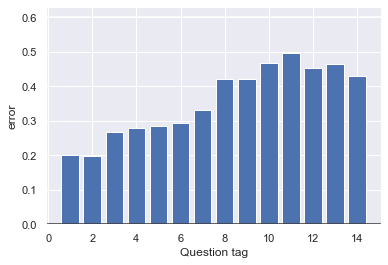

In [100]:
plt.bar(skills, cemal[0])
plt.ylabel('error')
plt.xlabel('Test Name')
plt.axhline(y=0, color='k')
plt.axhline(y=0.6, color='w')
plt.show()

In [12]:
from tensorflow_core import float32


predictedTensor=tf.convert_to_tensor(sample1,dtype=float32)

In [13]:
predictedTensor[0][(34)][10]

2022-05-28 20:17:28.747097: W tensorflow/core/framework/op_kernel.cc:1622] OP_REQUIRES failed at strided_slice_op.cc:108 : Invalid argument: slice index 34 of dimension 0 out of bounds.


InvalidArgumentError: slice index 34 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [14]:
student_desired[0]

TypeError: 'NoneType' object is not subscriptable

In [15]:
#### Part 9: Predict only one student from Desired Data Set

In [16]:
student_prediction=tf.expand_dims(predictedTensor, axis=0)

In [17]:
prediction_of_one_student=student_model.predict(tf.squeeze(student_prediction,axis=0))[0]
print(prediction_of_one_student.shape) #This is how the prediction output looks like
print(tf.squeeze(student_prediction,axis=0).shape)#this is how the input looks like see paper intuition doubling the skill_size
prediction_of_one_student[10] #prediction of last time step

(14, 14)
(1, 14, 28)


array([0.9598654 , 0.92397356, 0.939162  , 0.9693497 , 0.7270918 ,
       0.8869848 , 0.38009876, 0.9597237 , 0.86430526, 0.9546869 ,
       0.89323103, 0.96057236, 0.91414547, 0.69032866], dtype=float32)

In [18]:
count=14
averages=[]

for i in range (count):
    suma = 0
    for j in range(count):
        suma += prediction_of_one_student[i][j]
    averages.append(suma/count)

In [19]:
relationships = []
for i in range (count):
    relationship = []
    for j in range(count):
        relationship.append(prediction_of_one_student[i][j]/averages[i])
    relationships.append(relationship)

print(len(relationships))
print(len(relationships[0]))

14
14


In [20]:
df = pd.DataFrame(relationships, columns=[i for i in range(14)])

In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.269437,1.352097,1.256565,1.230383,0.876151,0.872027,0.806204,0.919679,0.833254,0.881611,0.903740,0.909047,0.956842,0.932963
1,1.466732,1.566658,1.613194,1.529207,0.831951,0.828084,0.585656,0.798306,0.643465,0.782928,0.804434,0.824925,0.903356,0.821107
2,1.687995,1.764611,1.774789,1.845457,0.824108,0.813801,0.413382,0.789862,0.472570,0.722708,0.672137,0.729828,0.825713,0.663040
3,1.738124,1.755173,1.788854,1.843730,0.970837,1.026676,0.306130,0.916260,0.396142,0.782076,0.497843,0.753157,0.715007,0.509992
4,1.555510,1.551161,1.595244,1.668972,1.110655,1.344452,0.375625,1.145279,0.450802,0.936551,0.411552,0.786627,0.653710,0.413858


In [22]:
corr = df.corr()

In [23]:
corr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.000000,0.988612,0.985239,0.987759,-0.037913,-0.177000,-0.042016,-0.662495,-0.899729,-0.900379,-0.659264,-0.868984,-0.694108,-0.288961
1,0.988612,1.000000,0.991859,0.966412,-0.180559,-0.312877,-0.035300,-0.763535,-0.887708,-0.948783,-0.551532,-0.839428,-0.604791,-0.162000
2,0.985239,0.991859,1.000000,0.970827,-0.158310,-0.273947,-0.126589,-0.734262,-0.917903,-0.918996,-0.555480,-0.804840,-0.593780,-0.181017
3,0.987759,0.966412,0.970827,1.000000,0.030276,-0.100355,-0.080005,-0.585670,-0.872454,-0.843539,-0.709527,-0.871892,-0.733851,-0.390253
4,-0.037913,-0.180559,-0.158310,0.030276,1.000000,0.962282,0.157143,0.748369,0.082612,0.384638,-0.703852,-0.199725,-0.617009,-0.860475
5,-0.177000,-0.312877,-0.273947,-0.100355,0.962282,1.000000,-0.004223,0.833699,0.152948,0.521498,-0.556835,-0.009036,-0.471518,-0.796270
6,-0.042016,-0.035300,-0.126589,-0.080005,0.157143,-0.004223,1.000000,-0.008606,0.361853,-0.126603,-0.216891,-0.404364,-0.320326,-0.102055
7,-0.662495,-0.763535,-0.734262,-0.585670,0.748369,0.833699,-0.008606,1.000000,0.606330,0.895588,-0.080785,0.458129,0.018423,-0.479129
8,-0.899729,-0.887708,-0.917903,-0.872454,0.082612,0.152948,0.361853,0.606330,1.000000,0.779819,0.487912,0.607318,0.471591,0.121701
9,-0.900379,-0.948783,-0.918996,-0.843539,0.384638,0.521498,-0.126603,0.895588,0.779819,1.000000,0.357357,0.783489,0.450838,-0.087644


In [24]:
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

In [28]:
links_filtered=links.loc[ (links['value'] > 0.1) & (links['var1'] != links['var2']) ]
links_filtered=links_filtered[links_filtered.var1.isnull() == False]
links_filtered=links_filtered[links_filtered.var2.isnull() == False]

links_filtered = links_filtered.sort_values(by=['value'],ascending=False)
links_filtered = links_filtered.groupby('var1').head(3)

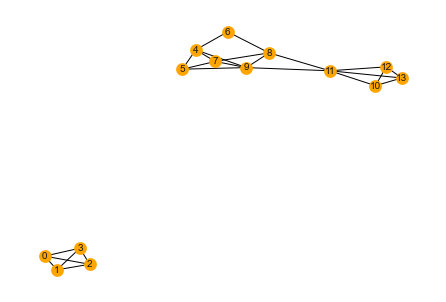

In [33]:
import networkx as nx

# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=60, edge_color='black', linewidths=5, font_size=10,pos=nx.spring_layout(G))

In [32]:
A = nx.adjacency_matrix(G)
A.todense()[0]

matrix([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])